# Samples' preparation


In [1]:
from os import listdir
import librosa
import librosa.display
import IPython
import os
import pandas as pd
import soundfile as sf
import random
import numpy as np

path_to_data = "/media/hdd/dataset/joined_v2/"

files = [f for f in listdir(path_to_data)]
print(files[:10])

['20_17.wav', '46_21.wav', '23_6.wav', '05_41.wav', '49_0.wav', '11_45.wav', '01_44.wav', '25_12.wav', '52_25.wav', '17_27.wav']


Open a random file and look at its waveform.

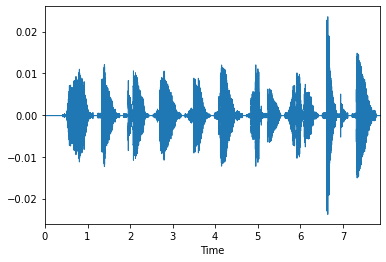

In [2]:
AUDIO_FILE = path_to_data + files[123]
y, sr = librosa.load(AUDIO_FILE, sr=None)
librosa.display.waveplot(y, sr=sr)

It can be seen that there is a small pause between each digit and there are 10 separate signals on the chart.

We trim the pauses at the beginning and at the end of each record.

In [3]:
top_db = 80
frame_length = 16
hop_length = 15

trimmed_ys = []
sample_rates = []
trim_ratios = []
for audio_name in files:
  AUDIO_FILE = path_to_data + audio_name
  y, sr = librosa.load(AUDIO_FILE, sr=None)
  yt, _ = librosa.effects.trim(y, top_db=top_db, frame_length=frame_length, hop_length=hop_length)
  trimmed_ys.append(yt)
  sample_rates.append(sr)
  trim_ratios.append(librosa.get_duration(yt)/librosa.get_duration(y))

In [4]:
print(min(trim_ratios), max(trim_ratios))

0.905383082713169 1.0


Making sure all audio files have the same sample rate

In [5]:
print(set(sample_rates))

{22050}


Next, we will divide the audio files into 10 fragments (by the number of digits) using the librosa.effects.split function, it goes through the recording with a certain step and window size, calculates the average amplitude value in the window, and if this value is below a percentage of the maximum amplitude, then the file is divided by this frame.
Actually, here we are trying to choose these parameters in such a way that the maximum number of files is divided into 10 parts.

In [6]:
top_dbs = list(range(10, 80, 10))
frame_lengths = [ 2**x for x in range(1, 12) ]
hop_lengths = [ 2**x for x in range(1, 12) ]

best_ratio = 0
best_splits_nums = None
best_top_db = None
best_frame_length = None
best_hop_length = None
for top_db in top_dbs:
  for frame_length in frame_lengths:
    for hop_length in hop_lengths:
      if hop_length <= frame_length:
        splits_nums = []
        count = 0
        for yt in trimmed_ys:
          inter = librosa.effects.split(yt, top_db=top_db, frame_length=frame_length, hop_length=hop_length)
          splits_num = len(inter)
          splits_nums.append(splits_num)
          if splits_num == 10:
            count += 1

        cur_ratio = count/len(files)
        if cur_ratio > best_ratio:
            best_ratio = cur_ratio
            best_splits_nums = splits_nums
            best_top_db = top_db
            best_frame_length = frame_length
            best_hop_length = hop_length
            print("Curent best at ", best_top_db, best_frame_length, best_hop_length)
            print("Current best ratio ", best_ratio)
            print("Current other splits ", set(best_splits_nums))

Curent best at  50 256 256
Current best ratio  0.916271186440678
Current other splits  {10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 27}
Curent best at  50 512 256
Current best ratio  0.9667796610169491
Current other splits  {10, 11, 12, 13, 14, 15, 16, 17, 18, 19}
Curent best at  50 512 512
Current best ratio  0.976271186440678
Current other splits  {10, 11, 12, 13, 14, 15, 16}
Curent best at  50 1024 256
Current best ratio  0.9861016949152542
Current other splits  {10, 11, 12, 13, 14, 15}
Curent best at  50 1024 512
Current best ratio  0.9894915254237289
Current other splits  {1, 10, 11, 12, 13, 14}
Curent best at  50 1024 1024
Current best ratio  0.9942372881355932
Current other splits  {1, 9, 10, 11, 12}


As a result of the search, we found that the best parameters are:

In [7]:
top_db = 50
frame_length = 1024
hop_length = 1024

splitted_ys = []
count = 0
for yt in trimmed_ys:
    inter = librosa.effects.split(yt, top_db=top_db, frame_length=frame_length, hop_length=hop_length)
    splits_num = len(inter)
    if splits_num == 10:
      split = []
      for ranges in inter:
        split.append(yt[ranges[0]:ranges[1]])
      splitted_ys.append(split)

We read arbitrary numbers for an arbitrary file. We make sure that they are properly cut.

In [8]:
sample = splitted_ys[2080][3]
print(len(splitted_ys))
sr=22050
IPython.display.Audio(sample, rate=sr, autoplay=True)

2933


Save the sliced files and create a csv file with metadata.

In [11]:
directory = "clean_joined_v2/"
parent_dir = "/media/hdd/dataset/"
clean_dir_path = os.path.join(parent_dir, directory)

os.mkdir(clean_dir_path)

In [9]:
df = pd.DataFrame(columns=["relative_path", "classID"])
sr = 22050

for idx, speaker in enumerate(splitted_ys):
  for digit in range(0, 10):
    file_name = str(idx) + "_" + str(digit) + ".wav"
    path = os.path.join(clean_dir_path, file_name)
    y = speaker[digit]

    sf.write(path, y, sr)
    new_row = {"relative_path":file_name, "classID": digit}
    df = df.append(new_row, ignore_index=True)

We generate records that do not belong to any of the classes.
Initially, it was noise, but as it turned out, the classifier works quite poorly with this. So I take a random sample, flip it around so it looks like human speech but not the sample itself, and then randomly stretch it over time and randomly rotate different harmonics.

In [13]:
def generate_false_samples(y: np.ndarray, sample_rate: int) -> Tuple[np.ndarray, int]:
    """
    Takes a randomly selected sample, inverse it, does timestretching and pitchshifting
    """
    sample = y.copy()[::-1]
    pitch_steps = random.randrange(-12, 12)
    sample = librosa.effects.pitch_shift(sample, sample_rate, n_steps=pitch_steps)
    sample = librosa.effects.time_stretch(sample, random.uniform(0.5, 2))
    return (sample, sample_rate)  



# Number of non-digits should be equal to number of other digits
non_digits_num = len(splitted_ys)


for i in range(non_digits_num):
  speaker_num = random.randint(0, len(splitted_ys)-1)
  digit_num = random.randint(0, 9)
  sample = splitted_ys[speaker_num][digit_num]
  
  y_mod, sr = generate_false_samples(sample, sr)
  number = 10
  file_name = str(non_digits_num) + "_" + str(number) + ".wav"
  non_digits_num += 1
  path = os.path.join(clean_dir_path, file_name)
  sf.write(path, y_mod, sr)
  new_row = {"relative_path":file_name, "classID": number}
  df = df.append(new_row, ignore_index=True)   

# Play the last audio, just to verify
IPython.display.Audio(y_mod, rate=sr, autoplay=True)

In [14]:
IPython.display.Audio(sample, rate=sr, autoplay=True)

In [15]:
df.to_csv(os.path.join(clean_dir_path, "data.csv"), index=False)  
df.tail()

,relative_path,classID
32260,5863_10.wav,10
32261,5864_10.wav,10
32262,5865_10.wav,10
32263,2_10.wav,10
32264,3_10.wav,10


# Pre-processing and augmentation


In [107]:
from os import listdir
import IPython
import os
import math, random
import torch
import torchaudio
from torchaudio import transforms
from IPython.display import Audio
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Tuple
from tqdm.notebook import tqdm

directory = "clean_joined_v2/"
parent_dir = "/media/hdd/dataset/"
clean_dir_path = os.path.join(parent_dir, directory)

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

We look at different versions of the spectrograms

In [108]:
df = pd.read_csv(os.path.join(clean_dir_path, "data.csv"))

idx = 132
sample, sr = torchaudio.load(os.path.join(clean_dir_path, df.loc[idx, "relative_path"]))
label = df.loc[idx, "classID"]
print(label)

sample = sample
IPython.display.Audio(sample, rate=sr, autoplay=True)

2


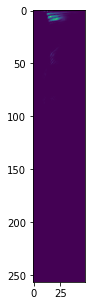

In [109]:
n_fft=512

spec = transforms.Spectrogram(n_fft=n_fft)(sample[0])
plt.figure(figsize=(18,5))
plt.imshow(spec)

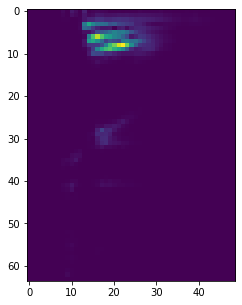

In [110]:
n_fft=512
n_mels=64
top_db=80


spec = transforms.MelSpectrogram(sr, n_fft=n_fft, n_mels=n_mels)(sample)[0]
plt.figure(figsize=(18,5))
plt.imshow(spec)

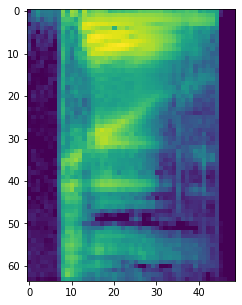

In [111]:
n_fft=512
n_mels=64
top_db=80


spec = transforms.MelSpectrogram(sr, n_fft=n_fft, n_mels=n_mels)(sample)
spec = transforms.AmplitudeToDB(top_db=top_db)(spec)[0]
plt.figure(figsize=(18,5))
plt.imshow(spec)

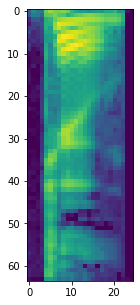

In [112]:
n_fft=1024
n_mels=64
top_db=80


spec = transforms.MelSpectrogram(sr, n_fft=n_fft, n_mels=n_mels)(sample)
spec = transforms.AmplitudeToDB(top_db=top_db)(spec)[0]
plt.figure(figsize=(18,5))
plt.imshow(spec)

It can be seen from the processing above that Mel spectrograms with amplitudes converted to dB highlight the most features.

Functions for opening and processing audio files:

In [113]:
def load(audio_file: str) -> Tuple[Tensor, int]:
  """
  Reads audio file to torch tensor and sample rate
  """
  aud, sr = torchaudio.load(audio_file)
  return (aud, sr)

def rechannel(aud: Tuple[Tensor, int], new_channel: int = 1) -> Tuple[Tensor, int]:
  """
  Takes the audio and changes it to mono/stereo, depending on 'new_channel' parameter
  """
  sig, sr = aud
  if (sig.shape[0] == new_channel):
    return aud
  if (new_channel == 1):
    # From stereo to mono
    resig = sig[:1, :]
  else:
    # From mono to stereo by duplicating the first channel
    resig = torch.cat([sig, sig])

  return ((resig, sr))

def pad_trunc(aud: Tuple[Tensor, int], max_ms: int = 4000) -> Tuple[Tensor, int]:
  """
  Adds zeros at the start and to the end of a signal, so it would have max_ms length
  """
  sig, sr = aud
  num_rows, sig_len = sig.shape
  max_len = sr//1000 * max_ms

  if (sig_len > max_len):
    # Truncate the signal
    sig = sig[:,:max_len]

  elif (sig_len < max_len):
    # Random length of padding to add at the beginning and end of the signal
    pad_begin_len = random.randint(0, max_len - sig_len)
    pad_end_len = max_len - sig_len - pad_begin_len
    pad_begin = torch.zeros((num_rows, pad_begin_len))
    pad_end = torch.zeros((num_rows, pad_end_len))

    sig = torch.cat((pad_begin, sig, pad_end), 1)
    
  return (sig, sr)

def spectrogram(aud: Tuple[Tensor, int], n_mels: int = 64, n_fft: int = 1024, 
                hop_len: int = 160, f_min: int = 0, f_max: int = 8000) -> Tensor:
  """
  Transforms normal audio to MelSpectrogram
  """
  sig,sr = aud
  top_db = 80

  # spec has shape [channel, n_mels, time], where channel is mono, stereo etc
  spec = transforms.MelSpectrogram(sr, n_fft=n_fft, n_mels=n_mels)(sig)
  # Convert amplitudes to decibels
  spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
  return (spec)


def spec_aug(spec: Tensor, max_mask_pct: float = 0.1, 
             n_freq_masks: int = 1, n_time_masks: int = 1) -> Tensor:
  """
  SpecAugmemt augmentation. Described in arxiv.org/pdf/1904.08779.pdf 
  """
  _, n_mels, n_steps = spec.shape
  mask_value = spec.mean()
  aug_spec = spec

  freq_mask_param = max_mask_pct * n_mels
  for _ in range(n_freq_masks):
    aug_spec = transforms.FrequencyMasking(freq_mask_param)(aug_spec, mask_value)

  time_mask_param = max_mask_pct * n_steps
  for _ in range(n_time_masks):
    aug_spec = transforms.TimeMasking(time_mask_param)(aug_spec, mask_value)

  return aug_spec

Dataset class. This defines all the features that we use when training and validating the model.

In [114]:
from torch.utils.data import DataLoader, Dataset, random_split


class DigitDataset(Dataset):
  """
  Dataset opens and transforms signal to spectrogram. 
  Depending on 'train' parameter it also adds augmentation (for training) or not (for validation). 
  """
  def __init__(self, df, data_path, train):
    self.df = df
    self.data_path = str(data_path)
    self.duration = 4000
    self.sr = 22050
    self.channel = 1
    self.max_mask_pct = 0.1
    self.n_freq_masks = 1
    self.n_time_masks = 1
    self.train = train
            
  def __len__(self):
    return len(self.df)    
    
  def __getitem__(self, idx):
    # Open file and get the label. 'data_path' is an absolute path to the dir
    audio_file = self.data_path + self.df.loc[idx, "relative_path"]
    class_id = self.df.loc[idx, "classID"]

    aud = load(audio_file)
    rechan = rechannel(aud, self.channel)
    dur_aud = pad_trunc(rechan, self.duration)
    sgram = spectrogram(dur_aud)
    aug_sgram = spec_aug(sgram, max_mask_pct=self.max_mask_pct, n_freq_masks=self.n_freq_masks, n_time_masks=self.n_time_masks)
    
    if self.train:
        return aug_sgram, class_id
    else:
        return sgram, class_id

In [115]:
from torch.utils.data import random_split
import pandas as pd 
from sklearn.model_selection import train_test_split


df = pd.read_csv(os.path.join(clean_dir_path, "data.csv"))

# Train/Validation split
train_df, val_df = train_test_split(df, test_size=0.2, random_state=2)
train_df.reset_index(inplace=True, drop=True)
val_df.reset_index(inplace=True, drop=True)

# The last boolean variable says if it's a train set (so, it should have augmentations) or not 
train_ds = DigitDataset(train_df, clean_dir_path, True)
val_ds = DigitDataset(val_df, clean_dir_path, False)

# Data loaders. Regulate batch_size and num_workers depending on your machine
batch_size = 64
num_workers = 9

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(val_ds, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers)

# Model training


As a model, I use a simple convolutional network like the one used in the pytorch example for mnist: https://github.com/pytorch/examples/blob/master/mnist/main.py ,
because it works quite well for classifying pictures and is quite compact at the same time.
A couple more layers of convolution were added and the rest of the parameters were chosen so that the network took less than 6 MB, but at the same time gave the best result. The dropout coefficients (0.15 and 0.25) were chosen empirically.

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class AudioClassifier(nn.Module):
    """
    Audio digits classifier based on simple mnist classifier
    """
    def __init__(self, n_classes):
        super(AudioClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1)
        self.conv4 = nn.Conv2d(128, 192, 3, 1)
        self.dropout1 = nn.Dropout(0.15)
        self.dropout2 = nn.Dropout(0.25)
        self.pooling = nn.AdaptiveAvgPool2d((8, 8))
        self.fc1 = nn.Linear(12288, 96)
        self.fc2 = nn.Linear(96, n_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)

        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = self.pooling(x)

        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x


myModel = AudioClassifier(11)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
myModel = myModel.to(device)

# Check that the model is working on Cuda
next(myModel.parameters()).device

device(type='cuda', index=0)

In [117]:
import pytorch_lightning as pl
import torchmetrics
metric = torchmetrics.Accuracy().to(device)


class MyLearner(pl.LightningModule):

    def __init__(self, model, learning_rate=3e-4):
        super().__init__()
        self.learning_rate = learning_rate
        self.model = model

    def forward(self, x):
        x = self.model(x)
        x = F.log_softmax(x, dim=1)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        return loss

    def validation_step(self, batch, batch_idx, split="val"):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = metric(preds, y)
        self.log(f"{split}_loss", loss, prog_bar=True)
        self.log(f"{split}_acc", acc, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        return self.validation_step(batch, batch_idx, split="test")

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def train_dataloader(self):
        return train_loader

    def val_dataloader(self):
        return valid_loader

    def test_dataloader(self):
        return test_loader

In [120]:
from tqdm.notebook import tqdm
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
learner = MyLearner(myModel).to(device)
checkpoint = pl.callbacks.ModelCheckpoint(monitor="val_acc")
trainer = pl.Trainer(gpus=-1, max_epochs=35, callbacks=[checkpoint])
trainer.fit(learner)

# Evaluation

def eval_model(model, device, dataloader):
    model = model.to(device).eval()
    y_true, y_pred = [], []
    for batch, labels in tqdm(dataloader, desc="Evaluation"):
        with torch.no_grad():
            outputs = model(batch.to(device))
        predictions = torch.argmax(outputs, dim=1)
        y_pred.append(predictions.to("cpu").numpy())
        y_true.append(labels.to("cpu").numpy())
    y_pred = np.concatenate(y_pred)
    y_true = np.concatenate(y_true)
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    clf_r = classification_report(y_true, y_pred)
    return {"y_pred": y_pred, "y_true": y_true, "accuracy": acc, "cm": cm, "clf_r": clf_r}


learner.load_state_dict(torch.load(checkpoint.best_model_path)["state_dict"])
results = eval_model(learner.model, device, valid_loader)
#plt.matshow(results["cm"])
print(results["cm"])
print(f"Accuracy: {results['accuracy']}")
print(results["clf_r"])

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type            | Params
------------------------------------------
0 | model | AudioClassifier | 1.5 M 
------------------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
5.979     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Evaluation:   0%|          | 0/101 [00:00<?, ?it/s]

[[568   0   6   1   0   0   0   3   0   0   0]
 [  0 561   0   0   0   2   0   0   0   9   0]
 [  4   0 569   1   0   0   0   0   0   0   0]
 [  0   0   0 600   0   0   0   2   2   0   0]
 [  2   1   1   0 606   2   0   0   0   0   0]
 [  0   0   0   0   2 557   0   0   0  11   0]
 [  0   0   0   2   0   0 567   6  12   0   0]
 [  0   0   4   0   1   0   0 618   0   0   0]
 [  0   0   1   4   0   0   1   0 586   0   0]
 [  1   0   0   1   0   0   0   0   0 573   0]
 [  2   1   0   1   3   2   7   0   2  12 536]]
Accuracy: 0.9826437315977065
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       578
           1       1.00      0.98      0.99       572
           2       0.98      0.99      0.99       574
           3       0.98      0.99      0.99       604
           4       0.99      0.99      0.99       612
           5       0.99      0.98      0.98       570
           6       0.99      0.97      0.98       587
           7       0

It can be seen that the model gives slightly worse results on the numbers that were at the edges, i.e. 0 and 9. It is quite possible that this is due to an imperfectly chosen coefficient when removing silence from the beginning and end of audio tracks. Otherwise, the model works quite well, the number of epochs for training was chosen experimentally.

A small boilerplate code in order to get the model from the checkpoints and save it in another folder

In [121]:
state_dict_path = "./final_model"
model_path = checkpoint.best_model_path
num_classes = 11

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
myModel = AudioClassifier(num_classes).to(device)
learner = MyLearner(myModel).to(device)
learner.load_state_dict(torch.load(model_path)['state_dict'])
torch.save(learner.model.state_dict(), state_dict_path)

Just some extra code to load and test the model again.

In [122]:
test_model = AudioClassifier(num_classes)
test_model.load_state_dict(torch.load(state_dict_path))
results = eval_model(test_model, device, valid_loader)
#plt.matshow(results["cm"])
print(results["cm"])
print(f"Accuracy: {results['accuracy']}")
print(results["clf_r"])

Evaluation:   0%|          | 0/101 [00:00<?, ?it/s]

[[572   0   2   1   0   0   0   3   0   0   0]
 [  0 560   0   0   0   1   0   0   0  11   0]
 [  2   0 571   1   0   0   0   0   0   0   0]
 [  0   0   0 604   0   0   0   0   0   0   0]
 [  1   2   1   0 605   3   0   0   0   0   0]
 [  0   2   0   1   1 554   0   0   0  12   0]
 [  0   0   0   0   0   0 576   4   7   0   0]
 [  0   0   1   0   1   0   0 621   0   0   0]
 [  0   0   0   4   0   0   2   0 586   0   0]
 [  1   0   0   1   0   0   0   0   0 573   0]
 [  2   2   0   0   1   1   8   0   1  12 539]]
Accuracy: 0.9857430652409732
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       578
           1       0.99      0.98      0.98       572
           2       0.99      0.99      0.99       574
           3       0.99      1.00      0.99       604
           4       1.00      0.99      0.99       612
           5       0.99      0.97      0.98       570
           6       0.98      0.98      0.98       587
           7       0

# Testing

Simply copied from the augmentation section, functions used for minimal file transformation

In [36]:
from torch import Tensor
from typing import List, Tuple
from tqdm.notebook import tqdm
from torchaudio import transforms
import torchaudio
from sklearn.metrics import accuracy_score

def load(audio_file: str) -> Tuple[Tensor, int]:
  """
  Reads audio file to torch tensor and sample rate
  """
  aud, sr = torchaudio.load(audio_file)
  return (aud, sr)

def rechannel(aud: Tuple[Tensor, int], new_channel: int = 1) -> Tuple[Tensor, int]:
  """
  Takes the audio and changes it to mono/stereo, depending on 'new_channel' parameter
  """
  sig, sr = aud
  if (sig.shape[0] == new_channel):
    return aud
  if (new_channel == 1):
    # From stereo to mono
    resig = sig[:1, :]
  else:
    # From mono to stereo by duplicating the first channel
    resig = torch.cat([sig, sig])

  return ((resig, sr))

def pad_trunc(aud: Tuple[Tensor, int], max_ms: int = 4000) -> Tuple[Tensor, int]:
  """
  Adds zeros at the start and to the end of a signal, so it would have max_ms length
  """
  sig, sr = aud
  num_rows, sig_len = sig.shape
  max_len = sr//1000 * max_ms

  if (sig_len > max_len):
    # Truncate the signal
    sig = sig[:,:max_len]

  elif (sig_len < max_len):
    # Random length of padding to add at the beginning and end of the signal
    pad_begin_len = random.randint(0, max_len - sig_len)
    pad_end_len = max_len - sig_len - pad_begin_len
    pad_begin = torch.zeros((num_rows, pad_begin_len))
    pad_end = torch.zeros((num_rows, pad_end_len))

    sig = torch.cat((pad_begin, sig, pad_end), 1)
    
  return (sig, sr)

def spectrogram(aud: Tuple[Tensor, int], n_mels: int = 64, n_fft: int = 1024, 
                hop_len: int = 160, f_min: int = 0, f_max: int = 8000) -> Tensor:
  """
  Transforms normal audio to MelSpectrogram
  """
  sig,sr = aud
  top_db = 80

  # spec has shape [channel, n_mels, time], where channel is mono, stereo etc
  spec = transforms.MelSpectrogram(sr, n_fft=n_fft, n_mels=n_mels)(sig)
  # Convert amplitudes to decibels
  spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
  return (spec)

In [37]:
def open_and_transform_wav(audio_file_path: str) -> Tensor:
    """
    Opens an audio file and returns it in a form of spectrogram
    """
    aud = load(audio_file_path)
    rechan = rechannel(aud)
    dur_aud = pad_trunc(rechan)
    sgram = spectrogram(dur_aud)
    return sgram

In [38]:
def infer_test_set(file_paths: List[str], model_path: str, num_classes : int = 11) -> List[int]:
    """
    arg file_paths: list of paths to wav files to be used as model inputs
    return: list of labels for each of input files.
    Use 0-9 as digit labels and -1 as a non-digit label
    """
    model = AudioClassifier(num_classes)
    model.load_state_dict(torch.load(model_path))
    model = model.to(device).eval()
    labels = []
    for path in tqdm(file_paths, desc="Inference"):
        with torch.no_grad():
            input_spgram = open_and_transform_wav(path) # read from path and transform
            # as model expects a batch as an input, we added [None, ...]
            output = model(input_spgram[None, ...].to(device))
        prediction = torch.argmax(output, dim=1)
        prediction = -1 if prediction == 10 else prediction
        labels.append(prediction.to("cpu").numpy())
    return labels

Next comes testing the previous function on local files

In [39]:
directory = "clean_joined_v2/"
parent_dir = "/media/hdd/dataset/"
clean_dir_path = os.path.join(parent_dir, directory)

df = pd.read_csv(os.path.join(clean_dir_path, "data.csv"))

file_paths = df["relative_path"].tolist()[:5]
file_paths = [os.path.join(clean_dir_path, path) for path in file_paths]
y_true = df["classID"].tolist()[:5]
print(file_paths)

['/media/hdd/dataset/clean_joined_v2/0_0.wav', '/media/hdd/dataset/clean_joined_v2/0_1.wav', '/media/hdd/dataset/clean_joined_v2/0_2.wav', '/media/hdd/dataset/clean_joined_v2/0_3.wav', '/media/hdd/dataset/clean_joined_v2/0_4.wav']


In [40]:
model_path = "./final_model"

y_pred = infer_test_set(file_paths, model_path)
acc = accuracy_score(y_true, y_pred)
print(acc)

Inference:   0%|          | 0/5 [00:00<?, ?it/s]

1.0


/home/k33p/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
